In [6]:
!pip install torch torchvision timm

In [7]:
!pip install timm

**BUILDING THE ViT ARCHITECTURE**

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import timm
from sklearn.metrics import accuracy_score

In [2]:
train = '/kaggle/input/medicinal-plant-bijly-withbg/Medicinal Plant-Bijly-withBG/Train'
validation = '/kaggle/input/medicinal-plant-bijly-withbg/Medicinal Plant-Bijly-withBG/Validation'
test = '/kaggle/input/medicinal-plant-bijly-withbg/Medicinal Plant-Bijly-withBG/Test'

In [3]:
# Configuration and Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
num_epochs = 10
learning_rate = 0.0001

# Data Transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Data Loaders
train_dataset = datasets.ImageFolder(root= train, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=validation, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Model Setup
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=len(train_dataset.classes))
model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}, Accuracy: {100 * correct / total}%")

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Validation Accuracy: {100 * correct / total}%")

# Save the trained model
torch.save(model.state_dict(), 'vit_medical_plants.pth')

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1, Loss: 0.2503781399393285, Accuracy: 92.08571428571429%
Validation Accuracy: 98.4%
Epoch 2, Loss: 0.08298504849345507, Accuracy: 97.68571428571428%
Validation Accuracy: 97.4%
Epoch 3, Loss: 0.07573521714313591, Accuracy: 97.54285714285714%
Validation Accuracy: 96.4%
Epoch 4, Loss: 0.051656805331797596, Accuracy: 98.57142857142857%
Validation Accuracy: 98.6%
Epoch 5, Loss: 0.039977904352566505, Accuracy: 98.71428571428571%
Validation Accuracy: 98.2%
Epoch 6, Loss: 0.03429650276974082, Accuracy: 98.77142857142857%
Validation Accuracy: 90.0%
Epoch 7, Loss: 0.048567960381412624, Accuracy: 98.51428571428572%
Validation Accuracy: 99.0%
Epoch 8, Loss: 0.05815502921342903, Accuracy: 98.17142857142858%
Validation Accuracy: 98.0%
Epoch 9, Loss: 0.056054439016754096, Accuracy: 98.11428571428571%
Validation Accuracy: 86.8%
Epoch 10, Loss: 0.06854625503586828, Accuracy: 97.91428571428571%
Validation Accuracy: 94.8%


**MODEL EVALUATION**

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import timm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=test, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Load the best model
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=len(train_dataset.classes))
model.load_state_dict(torch.load('/kaggle/working/vit_medical_plants.pth'))
model.to(device)
model.eval()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Evaluate on training data
train_loss, train_correct, train_total = 0, 0, 0
train_preds, train_targets = [], []
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)
        train_preds.extend(predicted.cpu().numpy())
        train_targets.extend(labels.cpu().numpy())

train_accuracy = accuracy_score(train_targets, train_preds)
train_precision = precision_score(train_targets, train_preds, average='weighted')
train_recall = recall_score(train_targets, train_preds, average='weighted')
train_f1 = f1_score(train_targets, train_preds, average='weighted')

# Evaluate on validation data
val_correct, val_total = 0, 0
val_preds, val_targets = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        val_correct += (predicted == labels).sum().item()
        val_total += labels.size(0)
        val_preds.extend(predicted.cpu().numpy())
        val_targets.extend(labels.cpu().numpy())

val_accuracy = accuracy_score(val_targets, val_preds)
val_precision = precision_score(val_targets, val_preds, average='weighted')
val_recall = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')

# Print metrics
print(f'Training Loss: {train_loss / len(train_loader):.4f}')
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Training Precision: {train_precision:.4f}')
print(f'Training Recall: {train_recall:.4f}')
print(f'Training F1 Score: {train_f1:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation Precision: {val_precision:.4f}')
print(f'Validation Recall: {val_recall:.4f}')
print(f'Validation F1 Score: {val_f1:.4f}')

Training Loss: 0.0481
Training Accuracy: 0.9831
Training Precision: 0.9836
Training Recall: 0.9831
Training F1 Score: 0.9831
Validation Accuracy: 0.9170
Validation Precision: 0.9352
Validation Recall: 0.9170
Validation F1 Score: 0.9163


**ViT EXPLAINABILITY**

In [16]:
!pip install baselines

  Using cached baselines-0.1.5-py3-none-any.whl
  Using cached zmq-0.0.0-py3-none-any.whl
  Using cached mpi4py-3.1.6.tar.gz (2.4 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached ale_py-0.8.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached mujoco-2.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (35 kB)
  Using cached pygame-2.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.5 kB)
  Using cached glfw-2.7.0-py2.py27.py3.py30.py31.py32.py33.py34.py35.py36.py37.py38-none-manylinux2014_x86_64.whl.metadata (5.4 kB)
  Using cached PyOpenGL-3.1.7-py3-none-any.whl.metadata (3.2 kB)
Using cached mujoco-2.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
Using cached pygame-2.1.0-cp310-cp310-manylinux_2_17_x86_64.man

In [17]:
pip install einops

Note: you may need to restart the kernel to use updated packages.


In [18]:
!git clone https://github.com/hila-chefer/Transformer-Explainability.git
import os
os.chdir(f'./Transformer-Explainability')


import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
import timm
from PIL import Image
from collections import OrderedDict
from modules.layers_ours import *
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

Cloning into 'Transformer-Explainability'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 386 (delta 3), reused 6 (delta 2), pack-reused 377
Receiving objects: 100% (386/386), 3.85 MiB | 19.81 MiB/s, done.
Resolving deltas: 100% (194/194), done.


In [19]:
CLS2IDX= {
          0: 'Bohera',
          1: 'Devil backbone',
          2: 'Horitoki',
          3: 'Lemon grass',
          4: 'Nayon Tara',
          5: 'Neem',
          6: 'Pathor kuchi',
          7: 'Thakuni',
          8: 'Tulsi',
          9: 'Zenora'
          }

In [20]:
#@title Perform thresholding on the relevance (using Otsu's method)
#@title Number of layers for image Transformer
use_thresholding =  False#@param {type:"boolean"}

In [21]:
mean = [0.485, 0.456, 0.406] # our images have three channels
std = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=mean, std=std)
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize,
])
resizing =  transforms.Resize((224,224))

In [22]:
#######################
num_classes = 10
model =  vit_LRP(pretrained=True)
num_ftrs = model.head.in_features
model.head = Linear(num_ftrs, num_classes)
# load state dictionary
state_dict = torch.load('/kaggle/working/vit_medical_plants.pth')
model.load_state_dict(state_dict)
model.cuda() # put model on GPU
model.eval()
attribution_generator = LRP(model)

In [23]:
import torch
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

In [24]:
#######################
# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

# Initialize the model
model = vit_LRP(pretrained=False, num_classes=10)  # Ensure num_classes matches your dataset
model = model.cuda()

# Load the saved state dictionary
state_dict = torch.load('/kaggle/working/vit_medical_plants.pth')
model.load_state_dict(state_dict)

model.eval()  # Set the model to evaluation mode
attribution_generator = LRP(model)


def generate_visualization(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
      transformer_attribution = transformer_attribution * 255
      transformer_attribution = transformer_attribution.astype(np.uint8)
      ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
      transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def print_top_classes(predictions, **kwargs):
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])

    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

Top 5 classes:
	1 : Devil backbone		value = 5.808	 prob = 95.5%
	9 : Zenora        		value = 2.468	 prob = 3.4%
	5 : Neem          		value = 0.290	 prob = 0.4%
	7 : Thakuni       		value = -0.168	 prob = 0.2%
	0 : Bohera        		value = -0.215	 prob = 0.2%


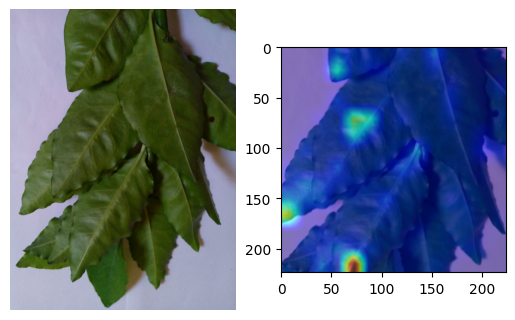

In [30]:
#######################################
image = Image.open('/kaggle/input/medicinal-plant-bijly-withbg/Medicinal Plant-Bijly-withBG/Train/Devilbackbone/(10).jpg')
original_image = transform(image)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(image);
axs[0].axis('off');

output = model(original_image.unsqueeze(0).cuda())
print_top_classes(output)

Devilbackbone = generate_visualization(original_image)

medical_plant = generate_visualization(original_image, class_index=5)

axs[1].imshow(Devilbackbone );
#axs[1].axis('off');